In [1]:
# !pip install ipywidgets widgetsnbextension pandas-profiling

In [2]:
# import pandas as pd
# from pandas_datareader import data
# import matplotlib.pyplot as plt
# # import seaborn as sns
# # import random
# import torch
# import numpy as np
# # from tqdm import tqdm

# Imports

In [3]:
from pandas_datareader import data
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

# Data Gathering

In [4]:
# GOOGL

# We would like all available data from 01/01/2000 until 12/31/2016.
start_date = '1993-01-30'  # '2014-01-01'  # 2012-10-21
end_date = '2022-12-01'  # '2014-10-20'  # 2022

# User pandas_reader.data.DataReader to load the desired data. As simple as that.
# panel_data = data.DataReader('IBM', 'yahoo', start_date, end_date)
panel_data = data.DataReader('SPY', 'yahoo', start_date, end_date)

# Resample the data to normalize it, the data comes without any data on the (days that the markets are close, weekends)
panel_data = panel_data.resample("D").max()

# Fill the data in the closed markets with the data from the previous trading day, because it is their true value
panel_data = panel_data.fillna(method="ffill")

panel_data[panel_data.index.name] = panel_data.index
panel_data.index.name = None
panel_data = panel_data[['Date', 'High', 'Low', 'Open', 'Close', 'Volume']]  # , 'Adj Close']]

panel_data.reset_index(drop=True, inplace=True)

# panel_data_ref = panel_data.copy()

# panel_data.head(20)

# Data Processing & Plotting Functions

In [5]:
def data_treatment(dataframe, ma=False):
    internal_df = dataframe.copy()

    if ma:
        internal_df[['Open', 'High', 'Low', 'Close', 'Volume']] = internal_df[['Open', 'High', 'Low', 'Close', 'Volume']].rolling(10).mean()
        close_plot_name = "Close Price (Daily) - Moving Average"
        volume_plot_name = "Volume (Daily) - Moving Average"
        # Drop all rows with NaN values
        internal_df.dropna(how='any', axis=0, inplace=True)
        date_df = pd.to_datetime(internal_df.pop('Date'), format='%Y-%m-%d')

    else:
        close_plot_name = "Close Price (Daily)"
        volume_plot_name = "Volume (Daily)"
        # Drop all rows with NaN values
        internal_df.dropna(how='any', axis=0, inplace=True) 
        date_df = pd.to_datetime(internal_df.pop('Date'), format='%Y-%m-%d')

    return internal_df, date_df, close_plot_name, volume_plot_name


In [6]:
def single_data_plotting(dataframe, date_df, close_plot_name, volume_plot_name):
    
    # Data plotting
    plt.figure(figsize=(15, 5))
    plt.plot(dataframe['Close'])
    plt.xticks(range(0, dataframe.shape[0], 1464), date_df.loc[::1464], rotation=0)
    plt.ylabel('Price', fontsize=18)
    plt.title(close_plot_name, fontsize=20)
    plt.legend(['Close Price'], fontsize='x-large', loc='best')
    plt.show()

    plt.figure(figsize=(15, 5))
    plt.plot(dataframe['Volume'])
    plt.xticks(range(0, dataframe.shape[0], 1464), date_df.loc[::1464], rotation=0)
    plt.ylabel('Volume', fontsize=18)
    plt.title(volume_plot_name, fontsize=20)
    plt.legend(['Volume'], fontsize='x-large', loc='best')
    plt.show()

In [7]:
def norm_percentage_xng(dataframe):
    internal_df = dataframe.copy()

    # Calculate percentage change
    internal_df['Open'] = internal_df['Open'].pct_change() 
    internal_df['High'] = internal_df['High'].pct_change()
    internal_df['Low'] = internal_df['Low'].pct_change() 
    internal_df['Close'] = internal_df['Close'].pct_change() 
    internal_df['Volume'] = internal_df['Volume'].pct_change()

    internal_df.dropna(how='any', axis=0, inplace=True) # Drop all rows with NaN values

    # Normalize price columns
    min_return = min(internal_df[['Open', 'High', 'Low', 'Close']].min(axis=0))
    max_return = max(internal_df[['Open', 'High', 'Low', 'Close']].max(axis=0))

    # Min-max normalize price columns (0-1 range)
    internal_df['Open'] =\
        (internal_df['Open'] - min_return) / (max_return - min_return)
    internal_df['High'] =\
        (internal_df['High'] - min_return) / (max_return - min_return)
    internal_df['Low'] =\
        (internal_df['Low'] - min_return) / (max_return - min_return)
    internal_df['Close'] =\
        (internal_df['Close'] - min_return) / (max_return - min_return)

    # Normalize volume column
    min_volume = internal_df['Volume'].min(axis=0)
    max_volume = internal_df['Volume'].max(axis=0)

    # Min-max normalize volume columns (0-1 range)
    internal_df['Volume'] =\
        (internal_df['Volume'] - min_volume) / (max_volume - min_volume)
    
    return internal_df

In [8]:
def data_splits(dataframe):
    internal_df = dataframe.copy()

    # Create training, validation and test split
    dates = sorted(internal_df.index.values)
    last_10pct = sorted(internal_df.index.values)[-int(0.1*len(dates))] # Last 10% of series
    last_20pct = sorted(internal_df.index.values)[-int(0.2*len(dates))] # Last 20% of series

    df_train = internal_df[(internal_df.index < last_20pct)]  # Training data are 80% of total data
    df_val = internal_df[(internal_df.index >= last_20pct) & (internal_df.index < last_10pct)]
    df_test = internal_df[(internal_df.index >= last_10pct)]

    # Convert pandas columns into arrays
    train_data = df_train.values
    val_data = df_val.values
    test_data = df_test.values
    # print(f'Training data shape: {train_data.shape}')
    # print(f'Validation data shape: {val_data.shape}')
    # print(f'Test data shape: {test_data.shape}')

    return train_data, df_train, val_data, df_val, test_data, df_test

In [9]:
def data_separation_plots(train_data, train_df, val_data, val_df, test_data, test_df):
    fig = plt.figure(figsize=(15,10))
    st = fig.suptitle("Data Separation", fontsize=20)
    st.set_y(0.92)

    ax1 = fig.add_subplot(211)
    ax1.plot(np.arange(train_data.shape[0]), train_df['Close'], label='Training data')

    ax1.plot(np.arange(train_data.shape[0], 
                    train_data.shape[0] + val_data.shape[0]), val_df['Close'], label='Validation data')

    ax1.plot(np.arange(train_data.shape[0] + val_data.shape[0], 
                    train_data.shape[0] + val_data.shape[0] + test_data.shape[0]), test_df['Close'], label='Test data')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Normalized Closing Returns')

    ax2 = fig.add_subplot(212)
    ax2.plot(np.arange(train_data.shape[0]), train_df['Volume'], label='Training data')

    ax2.plot(np.arange(train_data.shape[0], 
                    train_data.shape[0] + val_data.shape[0]), val_df['Volume'], label='Validation data')

    ax2.plot(np.arange(train_data.shape[0] + val_data.shape[0], 
                    train_data.shape[0] + val_data.shape[0] + test_data.shape[0]), test_df['Volume'], label='Test data')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Normalized Volume Changes')

    plt.legend(loc='best')

In [10]:
class DataSetter(Dataset):
    def __init__(self, data: np.ndarray, seq_len: int) -> None:
        """Init function of dataset class
       Args:
            data (np.ndarray): data from the dataframe to numpy
            seq_len (int): len of values to base for the prediction
        """
        self.inputs, self.targets = [], []
        
        for i in range(seq_len, len(data)):
            # Chunks of  data with a length of 128 df-rows
            self.inputs.append(data[i-seq_len:i])
            
            # Value of 4th column (Close Price) of df-row 128+1
            self.targets.append(data[:, 3][i])

        self.inputs, self.targets =\
            torch.FloatTensor(np.array(self.inputs)), torch.FloatTensor(np.array(self.targets))

    def __getitem__(self, idx: int) -> dict:
        """Get item at a certain index
        Args:
            idx (int): index to get the value
        Returns:
            dict: returns the input and the target
        """
        return {'inputs': self.inputs[idx],
                'targets': self.targets[idx]}
    
    def __len__(self) -> int:
        """Length function
        Returns:
            int: length of the Dataset
        """
        return min(len(self.inputs), len(self.targets))

In [11]:
def plot_t_v_loss(train_losses, test_losses, val_losses, test_preds, test_loader, train_loader):
    plt.title('Train and validation losses')

    # plt.plot(range(len(train_losses)), train_losses, label='train loss')
    plt.plot(range(len(test_losses)), test_losses, label='test loss')
    plt.plot(range(len(val_losses)), val_losses, label='validation loss')
    plt.legend()
    plt.show()

    plt.title('Test and Real predictions')
    plt.plot(np.concatenate(test_preds, axis=0), label='test predict')
    plt.plot(test_loader.dataset[:]['targets'], label= 'real predict', alpha =0.3)
    plt.legend()
    plt.show()

    plt.title('Train, Target and Predictions')
    test_predicts = np.concatenate(test_preds, axis=0)
    train_targets = train_loader.dataset[:]['targets']
    test_targets = test_loader.dataset[:]['targets']

    plt.plot(range(len(train_targets), len(train_targets) + len(test_targets)), test_targets, label='test targets', alpha= 0.3)
    plt.plot(range(0, len(train_targets)), train_targets, label='train targets', alpha=0.7) 
    plt.plot(range(len(train_targets), len(train_targets) + len(test_predicts)), test_predicts, label='test predictions')
    plt.legend()
    plt.show()

## Bidirectional LSTM

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_features):
        super(BiLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # batch_first=True -> first layer that takes in the DataSet
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size*2, num_features)
    
    def forward(self, x):
        # h0 = hidden state
        # c0 = cell state
        # self.num_layers * 2 -> tensor expanded x2 for concatenated state values of "going from begining to end and end to begining"
        # x.size(0) = number of examples sent in -> batch size
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device)

        out, (hiddenState, cellState) = self.lstm(x, (h0, c0))  # (hiddenState, cellState) are not used -> can be replaced as _
        # out[:, -1, :] -> select the last hidden state to send to the linear layer
        # [:, -1, :] -> [all training examples, last hidden state, all the features]
        # out = out.reshape(out.shape[0], -1)
        out = self.fc(out[:, -1, :])

        return out
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.num_layers * 2, batch_size, self.hidden_size).zero_().to(device),
                      weight.new(self.num_layers * 2, batch_size, self.hidden_size).zero_().to(device))
        return hidden



In [14]:
def train_network(train_loader, val_loader, model, criterion, optimizer, num_epochs, ma=False, folder='LSTM_Models'):

    model_name = 'state_dict.pt'
    model_name_complete = 'model_ma_complete.pt'
    if ma:
        model_name = 'state_ma_dict.pt'
        model_name_complete = 'model__ma_complete.pt'

    counter = 0
    print_every = 1
    valid_loss_min = np.Inf

    model.train()
    for epoch in range(num_epochs):
        train_losses = []
        for batch_idx, (data_combo) in enumerate(train_loader):

            # Identify Data
            data_in = data_combo['inputs']
            targets = data_combo['targets']
            
            # Get data to CUDA device
            data_in = data_in.to(device=device)#.squeeze(1)
            targets = targets.to(device=device).unsqueeze(1)
            # if ma:
            #     targets = targets.to(device=device)
            # print(data_in.size(), data_in)

            # # Get to correct shape
            # data_in = data_in.reshape(data_in.shape[0], -1)

            # forward
            scores = model(data_in)
            # print(scores, targets)
            # print(scores.size(), targets.size())
            loss = criterion(scores, targets)
            train_losses.append(loss.item())

            # backward
            optimizer.zero_grad()
            loss.backward()

            # gradient descent or Adam step
            optimizer.step()

            if counter%print_every == 0:
                val_losses = []
                
                model.eval()
                for data_combo_2 in val_loader:
                    inp, lab = data_combo_2['inputs'], data_combo_2['targets']
                    inp, lab = inp.to(device), lab.to(device)
                    out = model(inp)

                    val_loss = criterion(out.squeeze(), lab.float())
                    val_losses.append(val_loss.item())
                    
                model.train()

                if np.mean(val_losses) <= valid_loss_min:
                    print(f"Epoch: {epoch + 1}/{num_epochs}...",
                        f"Step: {batch_idx + 1}/{len(train_loader)}...",
                        f"Loss: {loss.item():.6f}...",
                        f"Val Loss: {np.mean(val_losses):.6f}")

                    # save model state (wights, etc.)
                    torch.save(model.state_dict(), f'{folder}//{model_name}')
                    # save complete model
                    torch.save(model, f'{folder}//{model_name_complete}')  
                    
                    print(f'Validation loss decreased \
                        ({valid_loss_min:.6f} --> {np.mean(val_losses):.6f}).  \
                        Saving model ...')
                    valid_loss_min = np.mean(val_losses)
    return train_losses, val_losses

In [15]:
def check_accuracy(test_loader, model, criterion, ma=False, folder='LSTM_Models'):
    # loading the model parameters (weights, etc.)
    model_name = 'state_dict.pt'
    model_name_complete = 'model_ma_complete.pt'
    if ma:
        model_name = 'state_ma_dict.pt'
        model_name_complete = 'model__ma_complete.pt'
    # model = torch.load(f'{folder}//{model_name_complete}')
    model.load_state_dict(torch.load(f'{folder}//{model_name}'))

    test_losses = []
    test_preds = []
    num_correct = 0
    # h = model.init_hidden(batch_size)

    model.eval()
    for (combo_data_3) in test_loader:
        inputs, labels = combo_data_3['inputs'], combo_data_3['targets']
        # h = tuple([each.data for each in h])
        inputs, labels = inputs.to(device), labels.to(device)
        # output, h = model(inputs, h)
        output = model(inputs)
        test_preds.append(output.cpu().detach().numpy())
        test_loss = criterion(output.squeeze(), labels.float())
        test_losses.append(test_loss.item())
        pred = torch.round(output.squeeze()) #rounds the output to 0/1
        correct_tensor = pred.eq(labels.float().view_as(pred))
        correct = np.squeeze(correct_tensor.cpu().numpy())
        num_correct += np.sum(correct)
            
    print("Test loss: {:.3f}".format(np.mean(test_losses)))
    # print(output)
    return test_losses, test_preds

# Variables definition

## Hyperparameters

In [16]:
sequence_length = 128
batch_size = 64
input_size = 5
hidden_size = 256
num_layers = 2
num_features = 1
learning_rate = 0.001
num_epochs = 2

## Functions Results

In [17]:
stock_dataframe, date_df, close_plot_name, volume_plot_name =\
    data_treatment(panel_data)

stock_dataframe_ma, date_df_ma, close_plot_name_ma, volume_plot_name_ma =\
    data_treatment(panel_data, True)

In [18]:
dataframe = norm_percentage_xng(stock_dataframe)
dataframe_ma = norm_percentage_xng(stock_dataframe_ma)

In [19]:
train_data, train_dataframe, val_data, val_dataframe, test_data, test_dataframe =\
    data_splits(dataframe)

train_data_ma, train_dataframe_ma, val_data_ma, val_dataframe_ma, test_data_ma, test_dataframe_ma =\
    data_splits(dataframe_ma)

In [20]:
train_dataset = DataSetter(data=train_data, seq_len=sequence_length)
val_dataset = DataSetter(data=val_data, seq_len=sequence_length)
test_dataset = DataSetter(data=test_data, seq_len=sequence_length)

train_dataset_ma = DataSetter(data=train_data_ma, seq_len=sequence_length)
val_dataset_ma = DataSetter(data=val_data_ma, seq_len=sequence_length)
test_dataset_ma = DataSetter(data=test_data_ma, seq_len=sequence_length)

In [21]:
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

train_loader_ma = DataLoader(dataset=train_dataset_ma, batch_size=batch_size, shuffle=False)
val_loader_ma = DataLoader(dataset=val_dataset_ma, batch_size=batch_size, shuffle=False)
test_loader_ma = DataLoader(dataset=test_dataset_ma, batch_size=batch_size, shuffle=False)

# Network

## Initialize BiLSTM

In [22]:
model = BiLSTM(input_size, hidden_size, num_layers, num_features).to(device)
model_ma = BiLSTM(input_size, hidden_size, num_layers, num_features).to(device)

In [23]:
print(model)

BiLSTM(
  (lstm): LSTM(5, 256, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=512, out_features=1, bias=True)
)


## Loss and optimizer

In [24]:
criterion = nn.MSELoss()  # nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
optimizer_ma = optim.Adam(model_ma.parameters(), lr=learning_rate)

## Train and Evaluate Network

In [25]:
train_losses, val_losses = train_network(train_loader, val_loader, model, criterion, optimizer, num_epochs)

model.zero_grad()
train_losses_ma, val_losses_ma = train_network(train_loader_ma, val_loader_ma, model_ma, criterion, optimizer_ma, num_epochs, True)

Epoch: 1/2... Step: 1/135... Loss: 0.246559... Val Loss: 0.159696
Validation loss decreased                         (inf --> 0.159696).                          Saving model ...
Epoch: 1/2... Step: 2/135... Loss: 0.160292... Val Loss: 0.083319
Validation loss decreased                         (0.159696 --> 0.083319).                          Saving model ...
Epoch: 1/2... Step: 3/135... Loss: 0.081867... Val Loss: 0.018783
Validation loss decreased                         (0.083319 --> 0.018783).                          Saving model ...
Epoch: 1/2... Step: 4/135... Loss: 0.018245... Val Loss: 0.013976
Validation loss decreased                         (0.018783 --> 0.013976).                          Saving model ...
Epoch: 1/2... Step: 6/135... Loss: 0.035206... Val Loss: 0.010141
Validation loss decreased                         (0.013976 --> 0.010141).                          Saving model ...
Epoch: 1/2... Step: 7/135... Loss: 0.009404... Val Loss: 0.000703
Validation loss decrease

C:\Users\João Ferreira\AppData\Roaming\Python\Python37\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1/2... Step: 1/135... Loss: 0.395821... Val Loss: 0.271557
Validation loss decreased                         (inf --> 0.271557).                          Saving model ...
Epoch: 1/2... Step: 2/135... Loss: 0.273122... Val Loss: 0.154614
Validation loss decreased                         (0.271557 --> 0.154614).                          Saving model ...
Epoch: 1/2... Step: 3/135... Loss: 0.149273... Val Loss: 0.045153
Validation loss decreased                         (0.154614 --> 0.045153).                          Saving model ...
Epoch: 1/2... Step: 4/135... Loss: 0.042470... Val Loss: 0.013741
Validation loss decreased                         (0.045153 --> 0.013741).                          Saving model ...
Epoch: 1/2... Step: 7/135... Loss: 0.011610... Val Loss: 0.001377
Validation loss decreased                         (0.013741 --> 0.001377).                          Saving model ...
Epoch: 1/2... Step: 22/135... Loss: 0.004380... Val Loss: 0.001297
Validation loss decreas

In [26]:
test_losses, test_preds = check_accuracy(test_loader, model, criterion)

test_losses_ma, test_preds_ma = check_accuracy(test_loader_ma, model_ma, criterion)

Test loss: 0.001
Test loss: 0.022


# Data Plotting

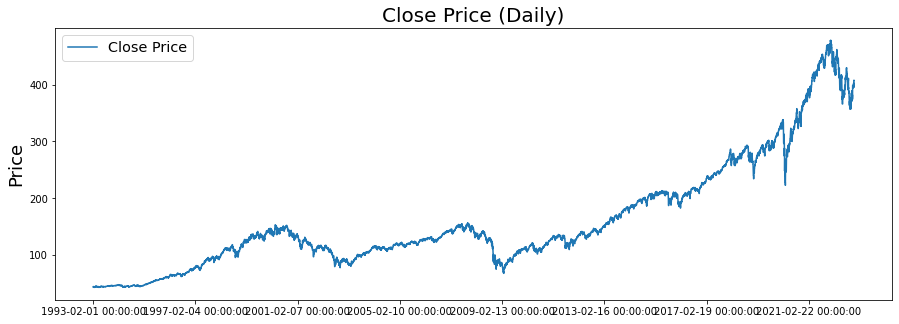

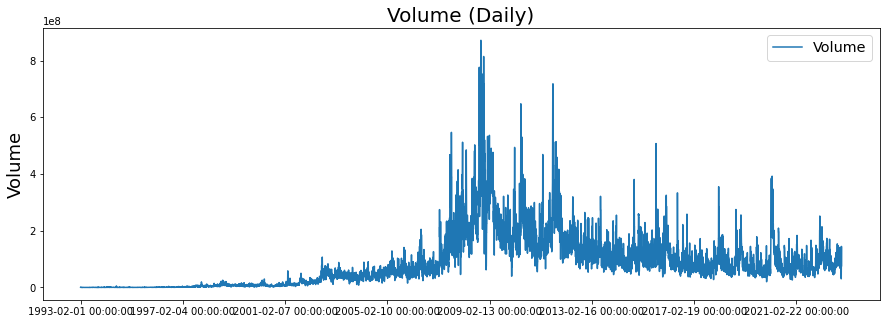

In [27]:
single_data_plotting(stock_dataframe, date_df, close_plot_name, volume_plot_name)

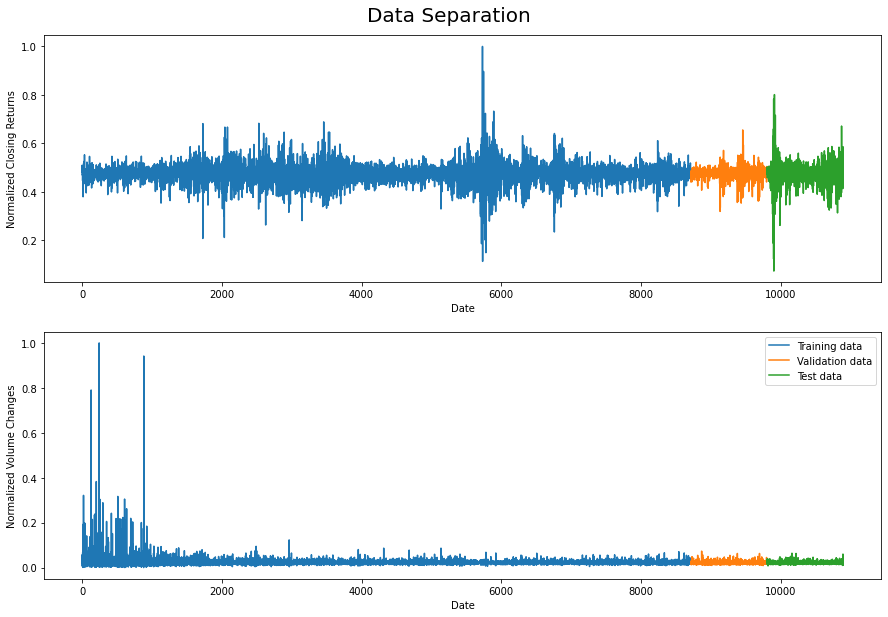

In [28]:
data_separation_plots(train_data, train_dataframe, val_data, val_dataframe, test_data, test_dataframe)

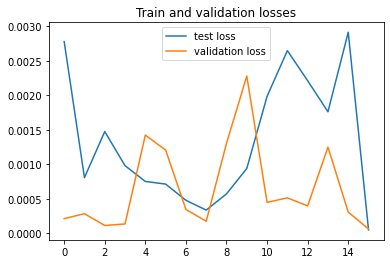

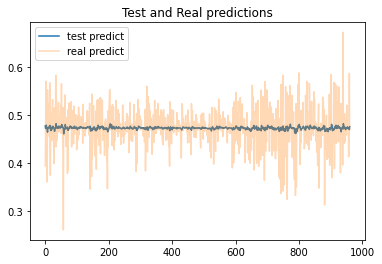

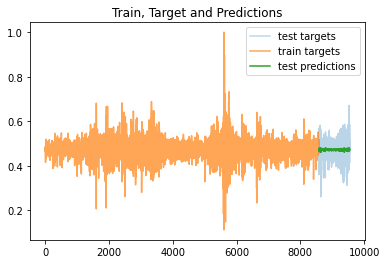

In [29]:
plot_t_v_loss(train_losses, test_losses, val_losses, test_preds, test_loader, train_loader)

## Moving Average Analysis

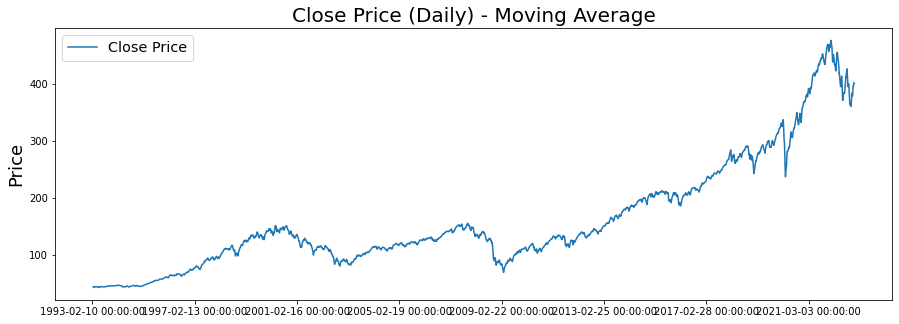

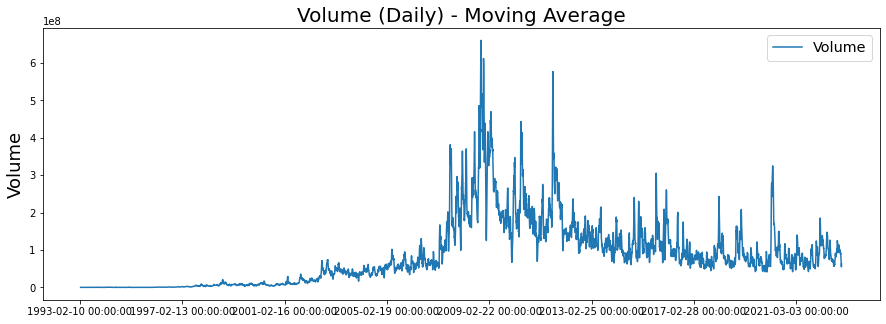

In [30]:
single_data_plotting(stock_dataframe_ma, date_df_ma, close_plot_name_ma, volume_plot_name_ma)

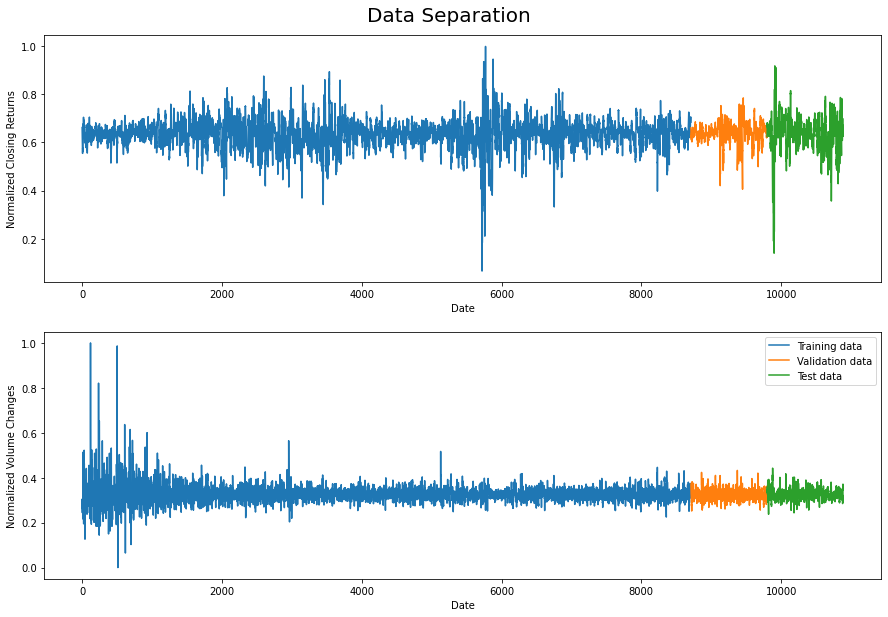

In [31]:
data_separation_plots(train_data_ma, train_dataframe_ma, val_data_ma, val_dataframe_ma, test_data_ma, test_dataframe_ma)

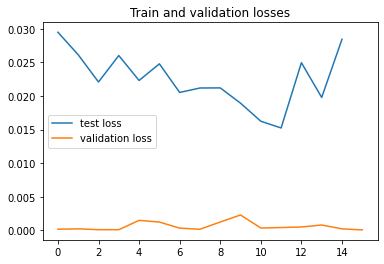

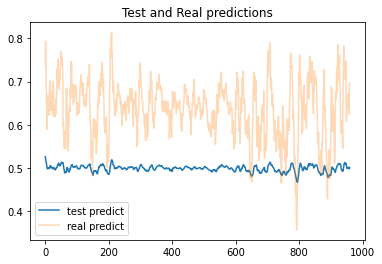

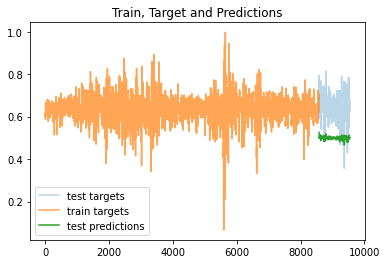

In [32]:
plot_t_v_loss(train_losses_ma, test_losses_ma, val_losses_ma, test_preds_ma, test_loader_ma, train_loader_ma)

## X

# Moving Average Analysis

In [33]:
batch_size = 64
train_loader_ma = DataLoader(dataset=train_dataset_ma, batch_size=batch_size, shuffle=False)
val_loader_ma = DataLoader(dataset=val_dataset_ma, batch_size=batch_size, shuffle=False)
test_loader_ma = DataLoader(dataset=test_dataset_ma, batch_size=batch_size, shuffle=False)

In [34]:
model_ma = BiLSTM(input_size, hidden_size, num_layers, num_features).to(device)

In [35]:
criterion = nn.MSELoss()  # nn.CrossEntropyLoss()
optimizer_ma = optim.Adam(model_ma.parameters(), lr=learning_rate)

In [36]:

test_losses_ma = []
test_preds_ma = []
num_correct_ma = 0
# h_ma = model_ma.init_hidden(batch_size)

model_ma.eval()
for (combo_data_3_ma) in test_loader_ma:
    inputs_ma, labels_ma = combo_data_3_ma['inputs'], combo_data_3_ma['targets']
    # h_ma = tuple([each.data for each in h_ma])
    inputs_ma, labels_ma = inputs_ma.to(device), labels_ma.to(device)
    # output, h = model(inputs, h)
    output_ma = model_ma(inputs_ma)
    test_preds_ma.append(output_ma.cpu().detach().numpy())
    test_loss_ma = criterion(output_ma.squeeze(), labels_ma.float())
    test_losses_ma.append(test_loss_ma.item())
    pred_ma = torch.round(output_ma.squeeze()) #rounds the output to 0/1
    correct_tensor_ma = pred_ma.eq(labels_ma.float().view_as(pred_ma))
    correct_ma = np.squeeze(correct_tensor_ma.cpu().numpy())
    num_correct_ma += np.sum(correct_ma)
        
print("Test loss: {:.3f}".format(np.mean(test_losses_ma)))

Test loss: 0.402


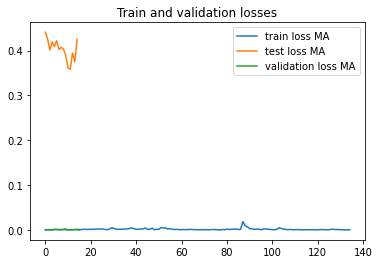

In [37]:
plt.title('Train and validation losses')

plt.plot(range(len(train_losses_ma)), train_losses_ma, label='train loss MA')
plt.plot(range(len(test_losses_ma)), test_losses_ma, label='test loss MA')
plt.plot(range(len(val_losses_ma)), val_losses_ma, label='validation loss MA')
plt.legend()
plt.show()

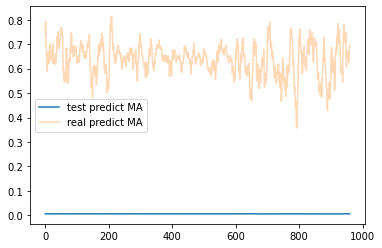

In [38]:
plt.plot(np.concatenate(test_preds_ma, axis=0), label='test predict MA')
plt.plot(test_loader_ma.dataset[:]['targets'], label= 'real predict MA', alpha =0.3)
plt.legend()
plt.show()

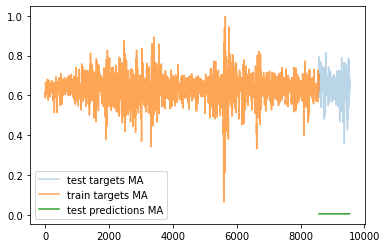

In [39]:
test_predicts_ma = np.concatenate(test_preds_ma, axis=0)
train_targets_ma = train_loader_ma.dataset[:]['targets']
test_targets_ma = test_loader_ma.dataset[:]['targets']

plt.plot(range(len(train_targets_ma), len(train_targets_ma) + len(test_targets_ma)), test_targets_ma, label='test targets MA', alpha= 0.3)

plt.plot(range(0, len(train_targets_ma)), train_targets_ma, label='train targets MA', alpha=0.7) 
plt.plot(range(len(train_targets_ma), len(train_targets_ma) + len(test_predicts_ma)), test_predicts_ma, label='test predictions MA')

plt.legend()


In [40]:
# # Moving Average - Testing different model architectures


# def create_model():
#   in_seq = Input(shape = (seq_len, 5))
      
#   x = Bidirectional(LSTM(128, return_sequences=True))(in_seq)
#   x = Bidirectional(LSTM(128, return_sequences=True))(x)
#   x = Bidirectional(LSTM(64, return_sequences=True))(x) 
          
#   avg_pool = GlobalAveragePooling1D()(x)
#   max_pool = GlobalMaxPooling1D()(x)
#   conc = concatenate([avg_pool, max_pool])
#   conc = Dense(64, activation="relu")(conc)
#   out = Dense(1, activation="sigmoid")(conc)      

#   model = Model(inputs=in_seq, outputs=out)
#   model.compile(loss="mse", optimizer="adam", metrics=['mae', 'mape'])    
#   return model

# model = create_model()

# #model.summary()
# #callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
# callback = tf.keras.callbacks.ModelCheckpoint('Bi-LSTM.hdf5', monitor='val_loss', save_best_only=True, verbose=1)

# model.fit(X_train, y_train,
#               batch_size=2048,
#               verbose=2,
#               callbacks=[callback],
#               epochs=200,
#               #shuffle=True,
#               validation_data=(X_val, y_val),)    

# model = tf.keras.models.load_model('/content/Bi-LSTM.hdf5')

# ###############################################################################
# '''Calculate predictions and metrics'''

# #Calculate predication for training, validation and test data
# train_pred = model.predict(X_train)
# val_pred = model.predict(X_val)
# test_pred = model.predict(X_test)

# #Print evaluation metrics for all datasets
# train_eval = model.evaluate(X_train, y_train, verbose=0)
# val_eval = model.evaluate(X_val, y_val, verbose=0)
# test_eval = model.evaluate(X_test, y_test, verbose=0)
# print(' ')
# print('Evaluation metrics')
# print('Training Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(train_eval[0], train_eval[1], train_eval[2]))
# print('Validation Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(val_eval[0], val_eval[1], val_eval[2]))
# print('Test Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(test_eval[0], test_eval[1], test_eval[2]))

# ###############################################################################
# '''Display results'''

# fig = plt.figure(figsize=(15,15))
# st = fig.suptitle("Moving Average - Bi-LSTM Model", fontsize=22)
# st.set_y(1.02)

# #Plot training data results
# ax11 = fig.add_subplot(311)
# ax11.plot(train_data[:, 3], label='IBM Closing Returns')
# ax11.plot(train_pred, label='Predicted IBM Closing Returns')
# ax11.set_title("Training Data", fontsize=18)
# ax11.set_xlabel('Date')
# ax11.set_ylabel('IBM Closing Returns')

# #Plot validation data results
# ax21 = fig.add_subplot(312)
# ax21.plot(val_data[:, 3], label='IBM Closing Returns')
# ax21.plot(val_pred, label='Predicted IBM Closing Returns')
# ax21.set_title("Validation Data", fontsize=18)
# ax21.set_xlabel('Date')
# ax21.set_ylabel('IBM Closing Returns')

# #Plot test data results
# ax31 = fig.add_subplot(313)
# ax31.plot(test_data[:, 3], label='IBM Closing Returns')
# ax31.plot(test_pred, label='Predicted IBM Closing Returns')
# ax31.set_title("Test Data", fontsize=18)
# ax31.set_xlabel('Date')
# ax31.set_ylabel('IBM Closing Returns')
 
# plt.tight_layout()
# plt.legend(loc='best')